## Competição antiga do kaggle 

Utilização de dados para estudos de análise exploratória, estátistica, machine learning, gráficos. 

Dados provém de vendas de casas e o objetivo é criar um algoritmo para prever o preço da casa antes de ser construída e se obter o menor RMSE (Root Mean Squared Error ou Média da Raiz Quadrada do Erro), que é uma metrica que mede a diferença entre o valor previsto do modelo com o valor observado. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import shapiro, skew, kurtosis
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

%matplotlib inline
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Importando em DataFrame as observações de treino e teste
df_treino = pd.read_csv('train.csv')
df_teste= pd.read_csv('test.csv')

df_treino.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_treino.iloc[809]

Id                  810
MSSubClass           75
MSZoning             RM
LotFrontage          90
LotArea            8100
                  ...  
MoSold               11
YrSold             2009
SaleType             WD
SaleCondition    Normal
SalePrice        106000
Name: 809, Length: 81, dtype: object

In [4]:
# Shape do dados treino e teste
print(df_treino.shape)
print(df_teste.shape)

(1460, 81)
(1459, 80)


In [5]:
# Informações do dados treino
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

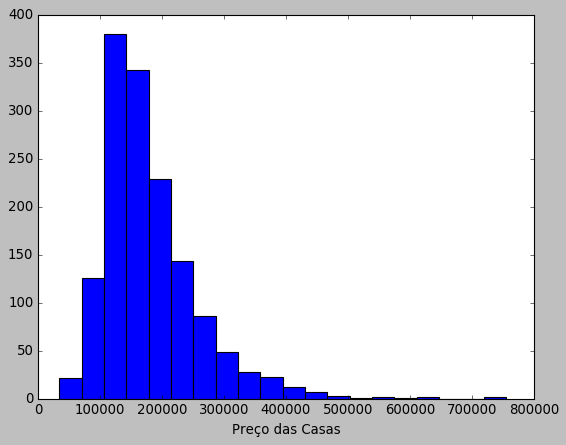

In [6]:
# Gráfico da variável target 'SalePrice', é notável que não segue uma distribuiçaõ normal mas conferir através
# dos valores de Skewness, Kurtosis, Shapiro Test.
plt.rcdefaults
plt.style.use('classic')
plt.hist(df_treino['SalePrice'], bins=20)
plt.xlabel('Preço das Casas');

In [7]:
# Valores de Shapiro Test, p-value, skewness, kurtosis
shap_test, p_value = shapiro(df_treino['SalePrice'])
target_skew = skew(df_treino['SalePrice'])
target_kurtosis = kurtosis(df_treino['SalePrice'])

print(f'Valor de Shapiro Teste (w): {shap_test}, Valor p_value: {p_value} ')
print(f'Valor de Skewness: {target_skew}')
print(f'Valor de Kurtosis: {target_kurtosis}')

Valor de Shapiro Teste (w): 0.869671642780304, Valor p_value: 3.206247534576162e-33 
Valor de Skewness: 1.880940746034036
Valor de Kurtosis: 6.509812011089439


Valor do p-value do teste de hipotese nula é extremamente baixo, então é descartada a hipotese nula, afirmando assim, que a variavel target "SalePrice" não possui uma curva normal. Também foi imprimido os valores de skew e kurtosis, que seria a prolongamento da cauda do gráfico e o achatamento da curva, respectivamente. 

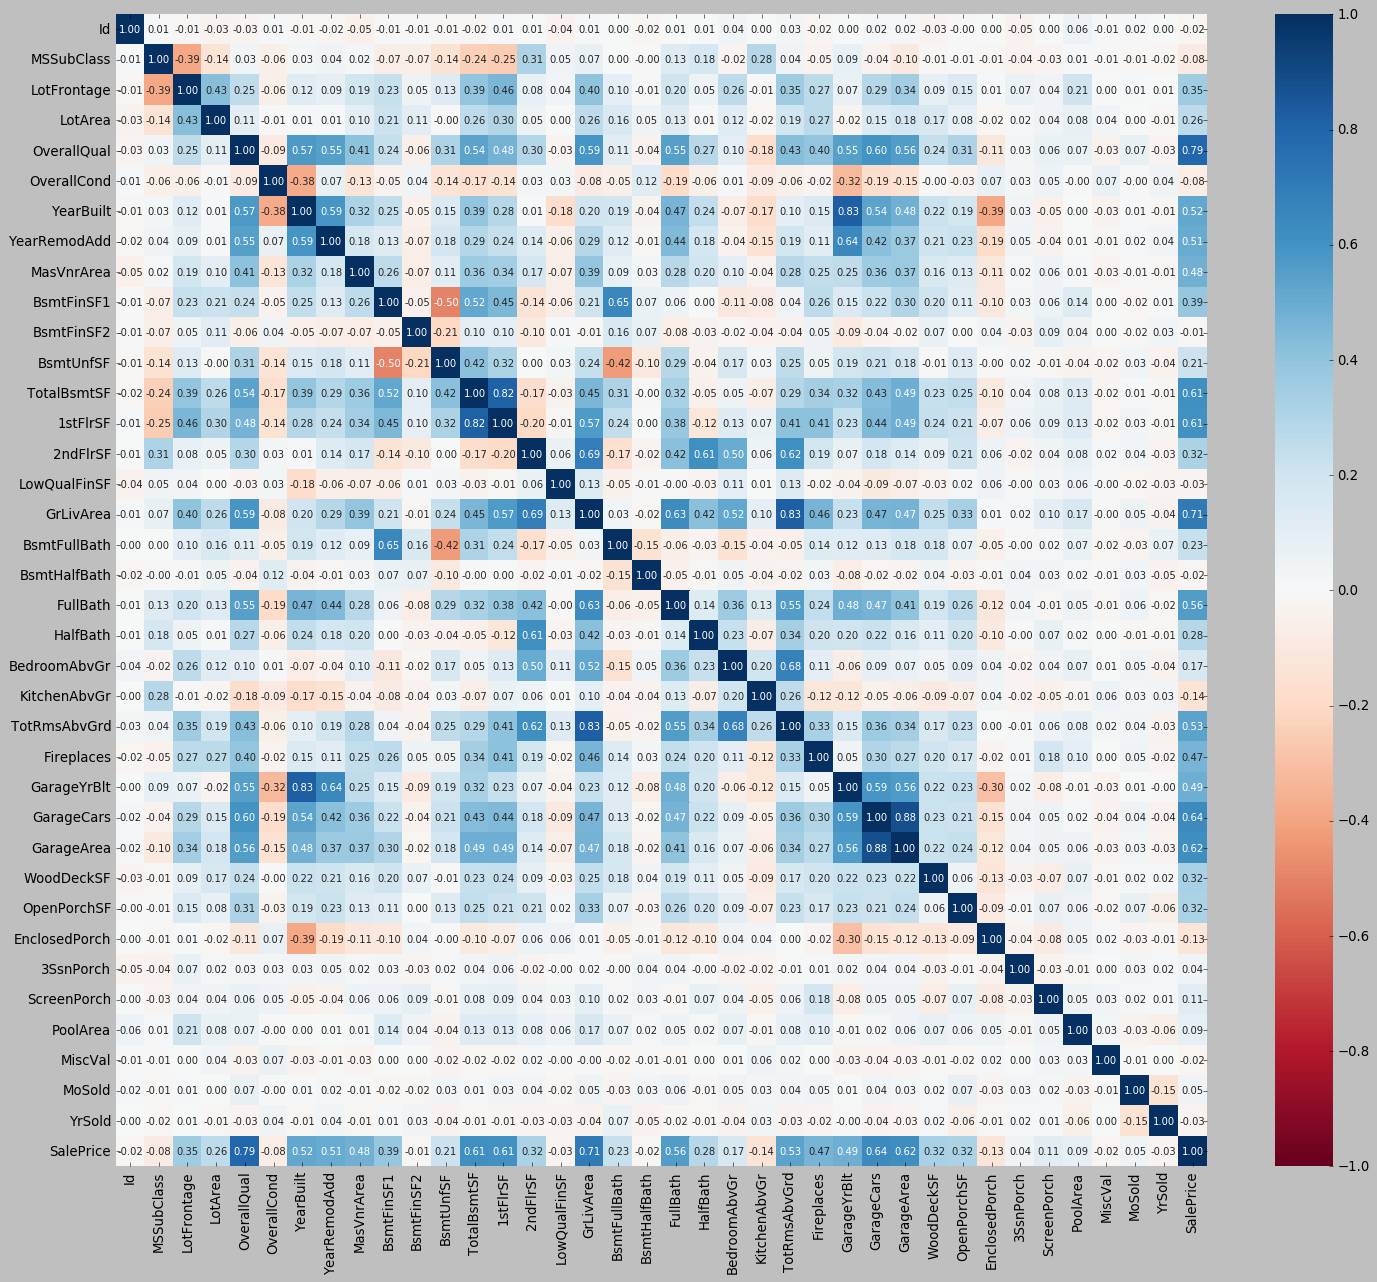

In [8]:
# Heatmap de correlação das váriaveis
plt.figure(figsize=(22,18))
sns.heatmap(df_treino.corr('pearson'), annot=True, cmap="RdBu", center=0, vmax=1, vmin=-1, annot_kws={'fontsize':9}, fmt='.2f');

Olhando para as correlações da váriavel target com o restante, é notável que umas tem valores maiores. E tem algumas váriaveis preditoras com alta correlação entre elas, o que causa problema de multicolinearidade. E agora vai ser feita análise dessas correlações:

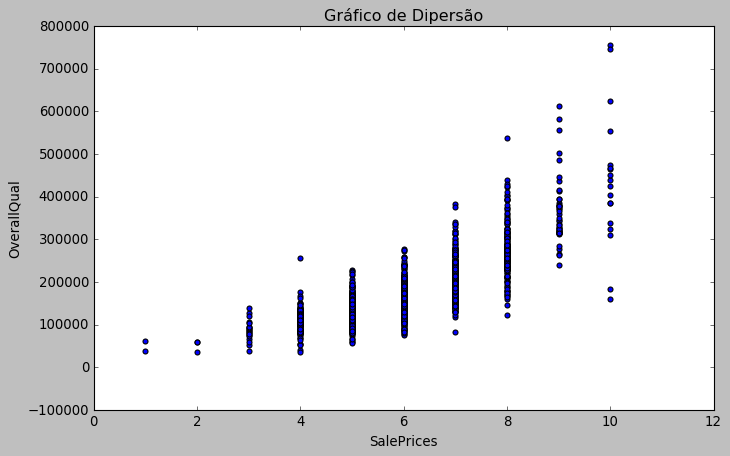

In [9]:
# Saleprice x OverallQual, pearson = 0,79
plt.figure(figsize=(10,6))
plt.scatter(x=df_treino['OverallQual'], y=df_treino['SalePrice'])
plt.xlabel('SalePrices')
plt.ylabel('OverallQual')
plt.title('Gráfico de Dipersão');

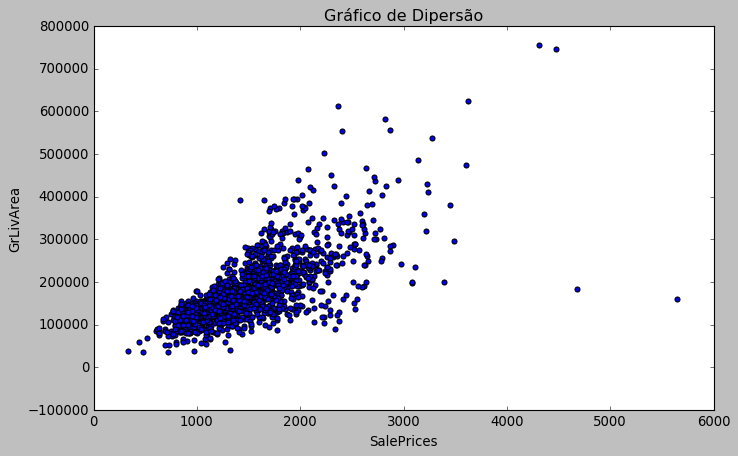

In [10]:
# Saleprice x GrLivArea, pearson=0,71
plt.figure(figsize=(10,6))
plt.scatter(x=df_treino['GrLivArea'], y=df_treino['SalePrice'])
plt.xlabel('SalePrices')
plt.ylabel('GrLivArea')
plt.title('Gráfico de Dipersão');

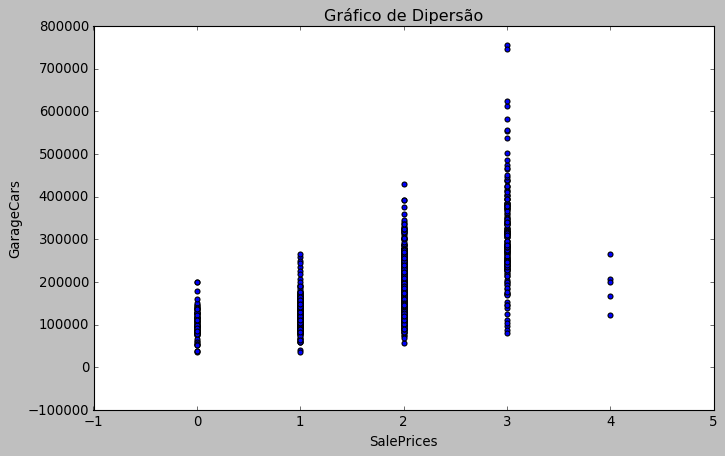

In [11]:
# Saleprice x GarageCars, pearson=0,64
plt.figure(figsize=(10,6))
plt.scatter(x=df_treino['GarageCars'], y=df_treino['SalePrice'])
plt.xlabel('SalePrices')
plt.ylabel('GarageCars')
plt.title('Gráfico de Dipersão');

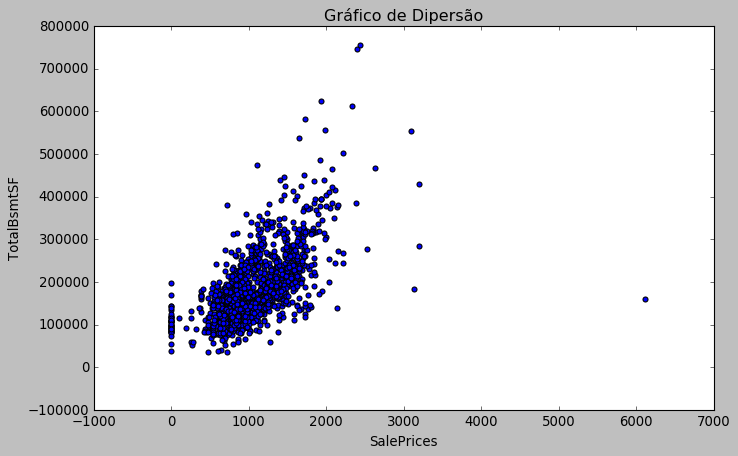

In [12]:
# Saleprice x TotalBsmtSF, pearson=0,64
plt.figure(figsize=(10,6))
plt.scatter(x=df_treino['TotalBsmtSF'], y=df_treino['SalePrice'])
plt.xlabel('SalePrices')
plt.ylabel('TotalBsmtSF')
plt.title('Gráfico de Dipersão');

In [13]:
# Váriaveis com baixa correlação retiradas das colunas
drop_corr_list = list(df_treino.corr()['SalePrice'][df_treino.corr()['SalePrice'] < 0.15].index[:])
drop_corr_list

['Id',
 'MSSubClass',
 'OverallCond',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [14]:
# Problema de multicolinearidade é resolvido apenas deixando uma váriavel com correlação com váriavel target

drop_corr_list.append('GarageYrBlt') # Alta correlação com YearBuilt, e tem valores missing
drop_corr_list.append('GrLivArea') # Alta correlação com TotRmsAbvGrd
drop_corr_list.append('BedroomAbvGr') # Alta correlação com TotRmsAbvGrd
drop_corr_list.append('GarageArea') # Alta correlação com CarageCars
drop_corr_list.append('1stFlrSF') # Alta correlação com TotalBsmtSF

drop_corr_list

['Id',
 'MSSubClass',
 'OverallCond',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'GarageYrBlt',
 'GrLivArea',
 'BedroomAbvGr',
 'GarageArea',
 '1stFlrSF']

In [15]:
# Lista de váriaveis com mais de 10% das observações missing de treino
drop_nan_list_treino = list(df_treino.isna().sum()[df_treino.isna().sum() > len(df_treino)*0.1].index[:])
print(drop_nan_list_treino)

# Lista de váriaveis com mais de 10% das observações missing de teste
drop_nan_list_teste = list(df_teste.isna().sum()[df_teste.isna().sum() > len(df_teste)*0.1].index[:])
print(drop_nan_list_teste)

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [16]:
# Separando váriavel target dos dados de treino
treino_y = df_treino['SalePrice']
treino_x = df_treino.drop(['SalePrice'], axis=1)

# Separando o Id do dados de teste
teste_x = df_teste.copy()
teste_id = df_teste['Id']

# Drop de colunas nos dados de teste e treino
treino_x.drop(drop_corr_list, axis=1, inplace= True)
treino_x.drop(drop_nan_list_treino, axis=1, inplace=True)
teste_x.drop(drop_corr_list, axis=1, inplace= True)
teste_x.drop(drop_nan_list_treino, axis=1, inplace=True)

In [17]:
# Tabela de valores missing treino
table_nan = pd.DataFrame(treino_x.isna().sum(), index= treino_x.columns, columns=['Valores_Missing'])
table_nan

,Valores_Missing
MSZoning,0
LotArea,0
Street,0
LotShape,0
LandContour,0
Utilities,0
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0


In [18]:
# Tabela de valores missing treino
table_nan_teste = pd.DataFrame(teste_x.isna().sum(), index= teste_x.columns, columns=['Valores_Missing'])
table_nan_teste

,Valores_Missing
MSZoning,4
LotArea,0
Street,0
LotShape,0
LandContour,0
Utilities,2
LotConfig,0
LandSlope,0
Neighborhood,0
Condition1,0


In [19]:
# Tratando váriaveis com valores missing de treino e teste. Valores missing assume valor da moda
for i in list(treino_x.columns):
    if (treino_x[i].isna().sum() / len(treino_x)):
        treino_x[i] = treino_x[i].fillna(treino_x[i].mode().values[0])
        
for i in list(teste_x.columns):
    if (teste_x[i].isna().sum() / len(teste_x)):
        teste_x[i] = teste_x[i].fillna(teste_x[i].mode().values[0])

In [20]:
# Valores Missing
print(teste_x.isna().sum().sum())
print(treino_x.isna().sum().sum())

0
0


In [21]:
# Separando váriaveis categóricas
var_cate = [i for i in treino_x.columns if treino_x.dtypes[i] == "object"]
df_cat_treino = treino_x[var_cate]
df_cat_teste = teste_x[var_cate]

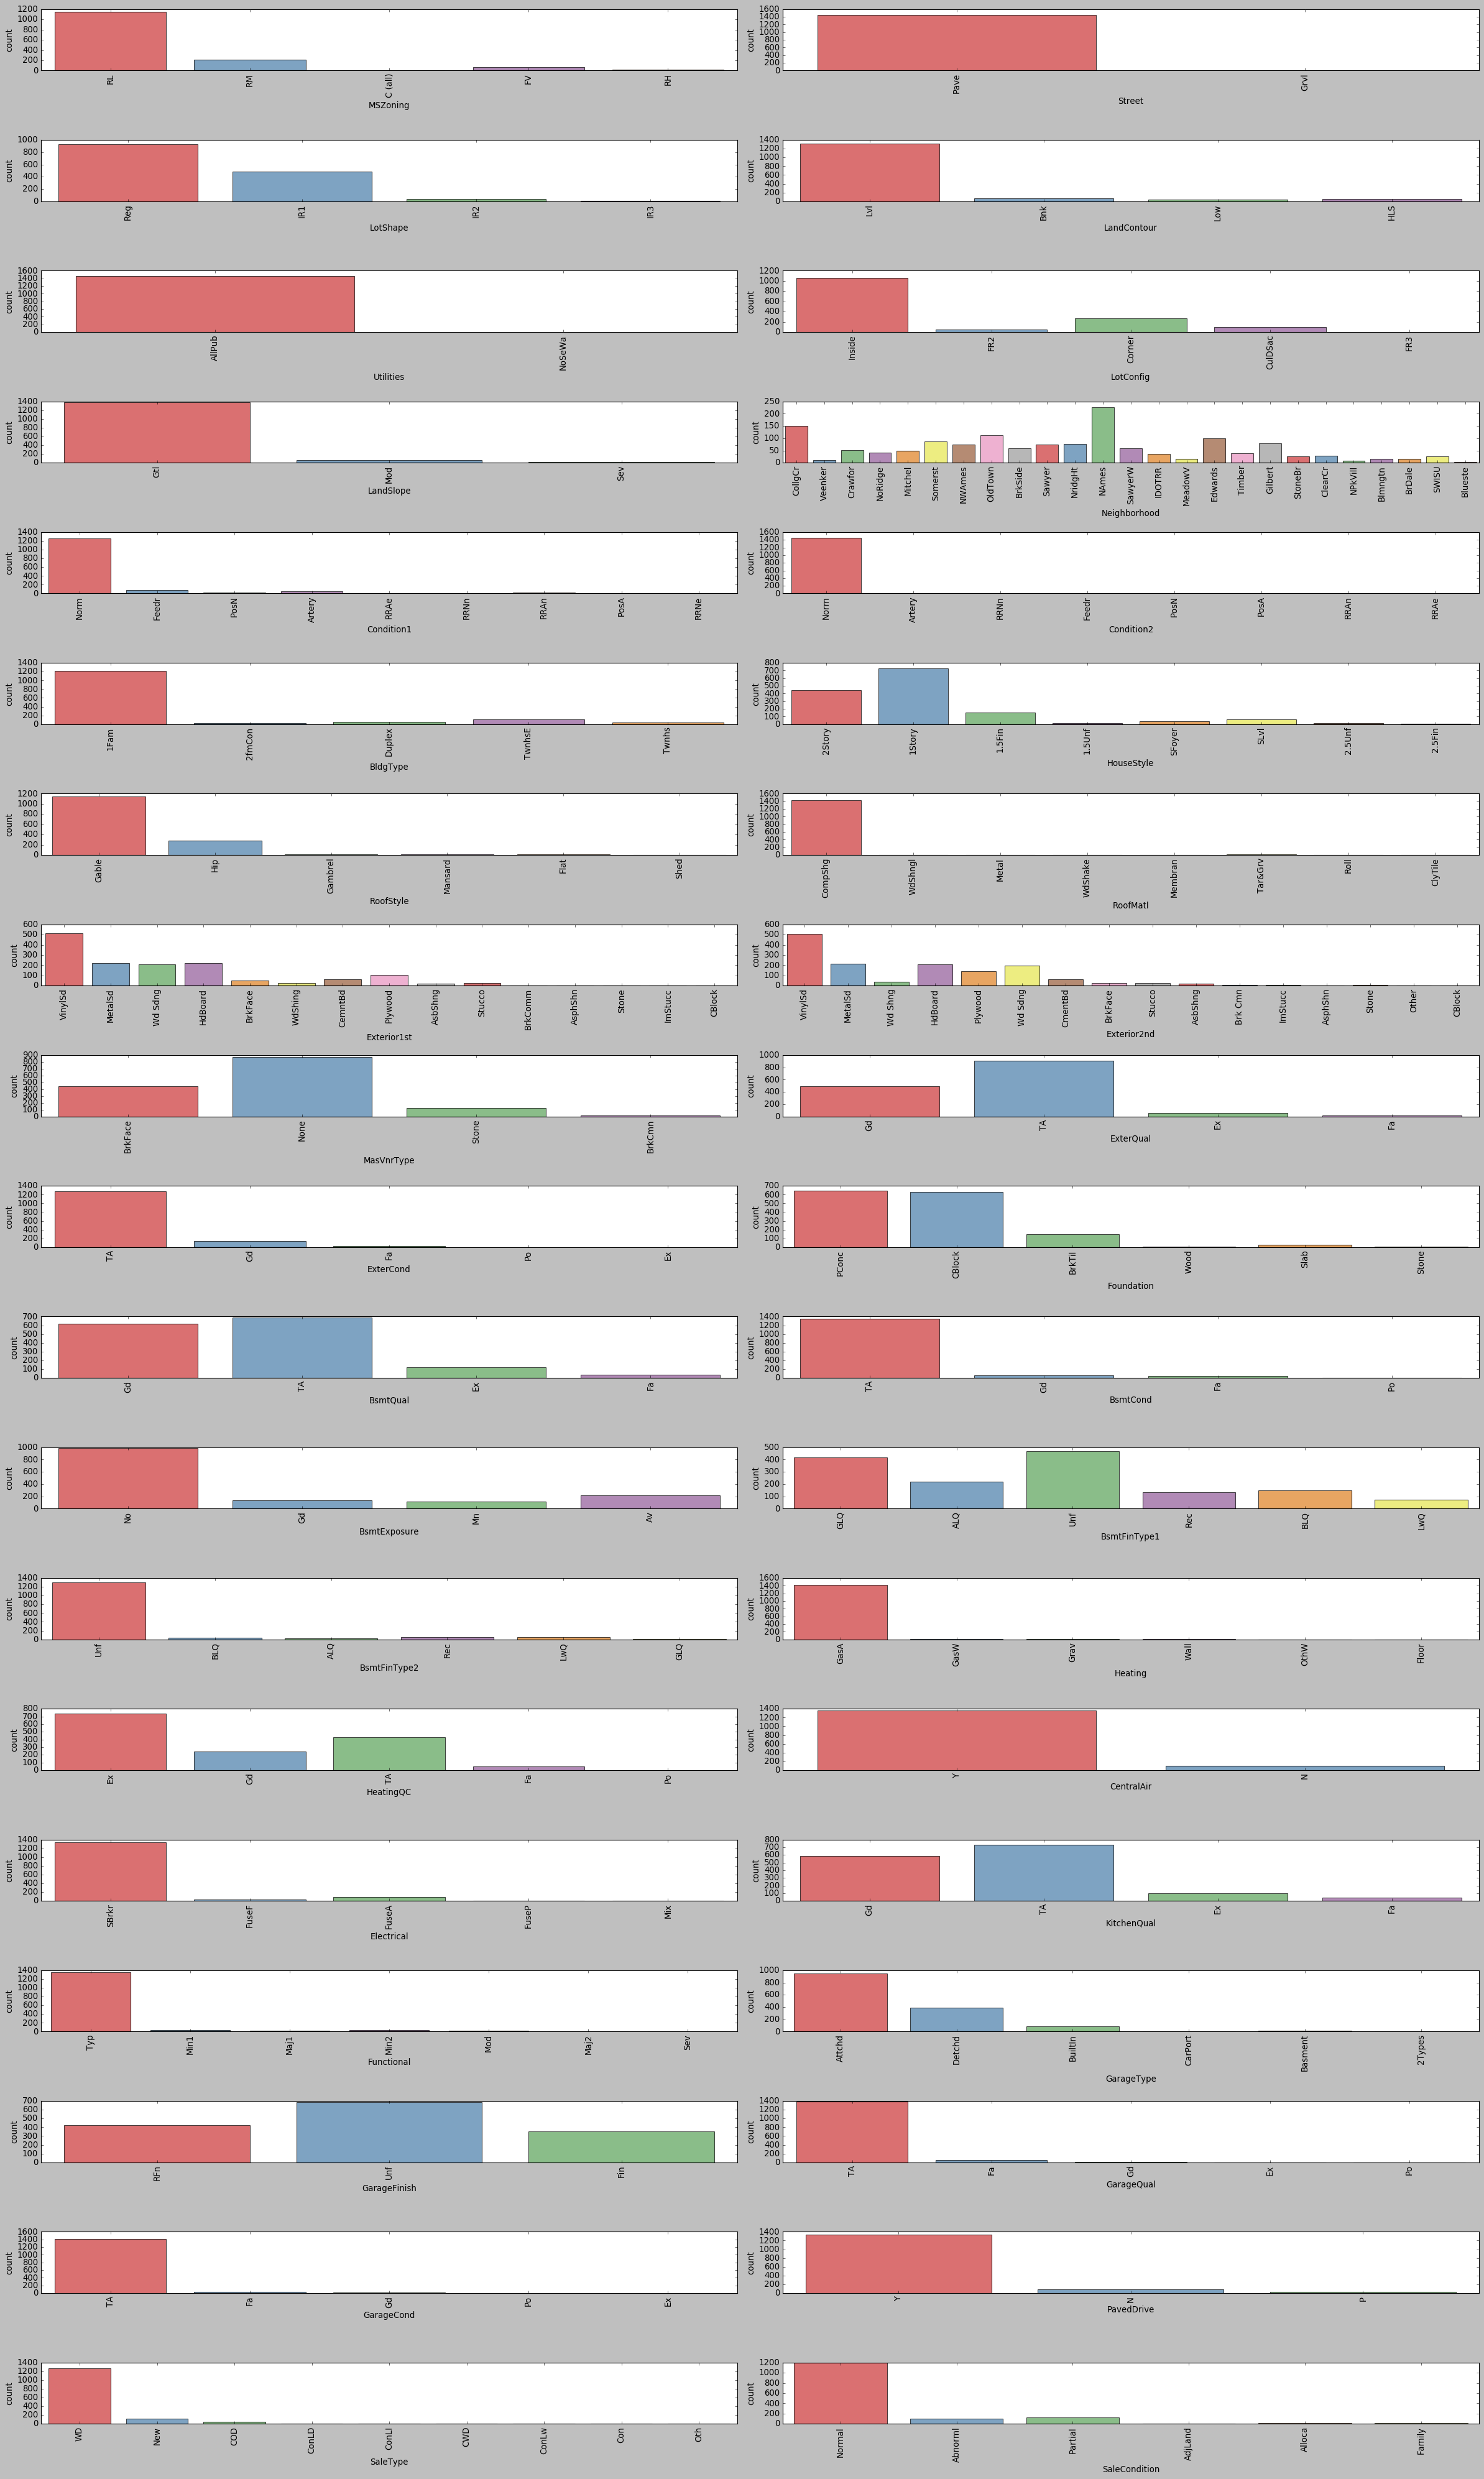

In [22]:
# Gráficos váriaveis categóricas
fig, axes = plt.subplots(round(len(df_cat_treino.columns) / 2), 2, figsize=(30, 50))

for i, ax in enumerate(fig.axes):
    # plot barplot of each feature
    if i < len(df_cat_treino.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=df_cat_treino.columns[i], alpha=0.7, data=df_cat_treino, ax=ax, palette = "Set1")

fig.tight_layout()

In [23]:
df_cat_treino.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [24]:
# colunas com altissimo valor unico
col_to_drop = ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'BsmtCond',
              'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond',
              'PavedDrive']

In [25]:
# drop de colunas
treino_x.drop(col_to_drop, axis=1, inplace=True)
teste_x.drop(col_to_drop, axis=1, inplace=True)
df_cat_treino.drop(col_to_drop, axis=1, inplace=True)
df_cat_teste.drop(col_to_drop, axis=1, inplace=True)

C:\Users\Alvim Serrao\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
# Conferindo se estão com mesma quantidade de várivael preditora 
print(treino_x.shape)
print(teste_x.shape)

(1460, 39)
(1459, 39)


In [27]:
# Dimensão dataframe de apenas váriavel categorica
print(df_cat_treino.shape)
print(df_cat_teste.shape)

(1460, 22)
(1459, 22)


In [28]:
# Criando uma lista com colunas no qual possui 90% de valores iguais nas observações
col_to_drop_2 = []
for i in df_cat_teste.columns:
    if ((df_cat_teste[i].value_counts().values[0]) / df_cat_teste[i].count()) > 0.9:
        col_to_drop_2.append(i)

col_to_drop_2

[]

In [29]:
# Funçaõ get_dummies identifica as váriaveis dtype object e cria novas colunas com valores de 0 e 1 
df_treino_all = pd.get_dummies(treino_x)
print(df_treino_all.shape)

df_teste_all = pd.get_dummies(teste_x)
print(df_teste_all.shape)

(1460, 172)
(1459, 168)


In [30]:
# Eliminando colunas que não é comum entre os teste e treino
col_nao_comum = [x for x in df_treino_all.columns if x not in df_teste_all.columns]
print(f"Colunas que tem no dataframe treino mas não tem no dataframe teste: {col_nao_comum}\n")

col_nao_comum_2 = [x for x in df_teste_all.columns if x not in df_treino_all.columns]
print(f"Colunas que tem no dataframe teste mas não tem no dataframe treino: {col_nao_comum_2}\n")

df_treino_all.drop(col_nao_comum, axis=1,inplace=True)

print(df_treino_all.shape)
print(df_teste_all.shape)

Colunas que tem no dataframe treino mas não tem no dataframe teste: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other']

Colunas que tem no dataframe teste mas não tem no dataframe treino: []

(1460, 168)
(1459, 168)


In [31]:
# Váriaveis importantes
print(df_treino_all.shape)
print(treino_y.shape)
print(df_teste_all.shape)
print(teste_id.shape)


(1460, 168)
(1460,)
(1459, 168)
(1459,)


As váriaveis YearBuilt e YearRemodAdd são ano de contrução e ano de remodelação, respectivamente. Serão alterados por quantidade de anos utilizando o último ano de registro do dataset.

In [32]:
# Função para realizar a alteração
def qnts_anos(dataframe_treino, dataframe_2, nome_coluna, nova_coluna):
    dataframe_2[nova_coluna] = dataframe_treino[nome_coluna].max() - dataframe_2[nome_coluna]

# Nova coluna em treino - Remod_Anos
qnts_anos(dataframe_treino=df_treino_all, dataframe_2= df_treino_all, nome_coluna='YearRemodAdd', nova_coluna='Remod_Anos')

# Nova coluna em treino - Constr_Anos
qnts_anos(dataframe_treino=df_treino_all, dataframe_2= df_treino_all, nome_coluna='YearBuilt', nova_coluna='Constr_Anos')

# Nova coluna em teste - Remod_Anos
qnts_anos(dataframe_treino=df_treino_all, dataframe_2= df_teste_all, nome_coluna='YearRemodAdd', nova_coluna='Remod_Anos')

# Nova coluna em teste - Constr_Anos
qnts_anos(dataframe_treino=df_treino_all, dataframe_2= df_teste_all, nome_coluna='YearBuilt', nova_coluna='Constr_Anos')

# Drop colunas
df_treino_all.drop('YearRemodAdd', inplace=True, axis=1)
df_treino_all.drop('YearBuilt', axis=1, inplace=True)
df_teste_all.drop('YearBuilt', axis=1, inplace=True)
df_teste_all.drop('YearRemodAdd', inplace=True, axis=1)


In [33]:
# Separando o dado de treino em treino e validação
x_treino, x_val, y_treino, y_val = train_test_split(df_treino_all, treino_y, train_size=.8 , random_state=101)

print(x_treino.shape)
print(y_treino.shape)
print(x_val.shape)
print(y_val.shape)

(1168, 168)
(1168,)
(292, 168)
(292,)


In [34]:
# Instanciando 
std = StandardScaler()

# Treino e transformação da normalização
std.fit(x_treino)
x_treino_std = std.fit_transform(x_treino)
x_val_std = std.fit_transform(x_val)
x_teste_std = std.fit_transform(df_teste_all)

### Algoritmo de Machine Learning

In [35]:
# Instaciando o algoritmo
reg = LinearRegression()

reg.fit(x_treino_std, y_treino)
pred_val = reg.predict(x_val_std)

medida_rmse = mean_squared_error(pred_val, y_val)
print(f'Valor da raiz quadrática média = {medida_rmse}')

Valor da raiz quadrática média = 5.823539856963564e+30


Valor extremamente alto, algoritmo ruim sem a capacidade de generalizar valor da casa.

In [36]:
# Usando o método kbest para escolher a quantidade e as melhores váriaveis para utilizar numa regressão linear
for k in range(5,161,5):
    k_best = SelectKBest(f_regression, k=k)
    
    x_treino_kbest = k_best.fit_transform(x_treino_std, y_treino)
    x_val_kbest = k_best.transform(x_val_std)

    reg = LinearRegression()

    reg.fit(x_treino_kbest, y_treino)
    pred_val = reg.predict(x_val_kbest)

    medida_rmse = mean_squared_error(pred_val, y_val)
    print(f'\nValor de k={k} e Valor RMSE = {medida_rmse}\n')
    print('*'*50)


Valor de k=5 e Valor RMSE = 1986497001.193367

**************************************************

Valor de k=10 e Valor RMSE = 1813784145.7687693

**************************************************

Valor de k=15 e Valor RMSE = 1816968561.9222128

**************************************************

Valor de k=20 e Valor RMSE = 1721703412.0990508

**************************************************

Valor de k=25 e Valor RMSE = 1841611403.0125353

**************************************************

Valor de k=30 e Valor RMSE = 1817486307.783987

**************************************************

Valor de k=35 e Valor RMSE = 1813810643.9570198

**************************************************

Valor de k=40 e Valor RMSE = 1748600344.948721

**************************************************

Valor de k=45 e Valor RMSE = 1734760884.1023653

**************************************************

Valor de k=50 e Valor RMSE = 1734711947.4478579

*********************************************

In [37]:
# Utilizando apenas o valor de k=60
k_best = SelectKBest(f_regression, k=60)
    
x_treino_kbest = k_best.fit_transform(x_treino_std, y_treino)
x_teste_kbest = k_best.transform(x_teste_std)

reg = LinearRegression()

reg.fit(x_treino_kbest, y_treino)
pred_test = reg.predict(x_teste_kbest)

In [38]:
# Transformando as previsões em um csv para fazer submit no kaggle
resposta = pd.DataFrame(teste_id, columns=['Id'])

resposta['SalePrice'] = pred_test

resposta.to_csv('resposta.csv', index=False)

### Referências
https://www.kaggle.com/code/marto24/beginners-prediction-top3/notebook

https://www.kaggle.com/code/emmanueldjegou/house-prices/notebook